[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SPY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


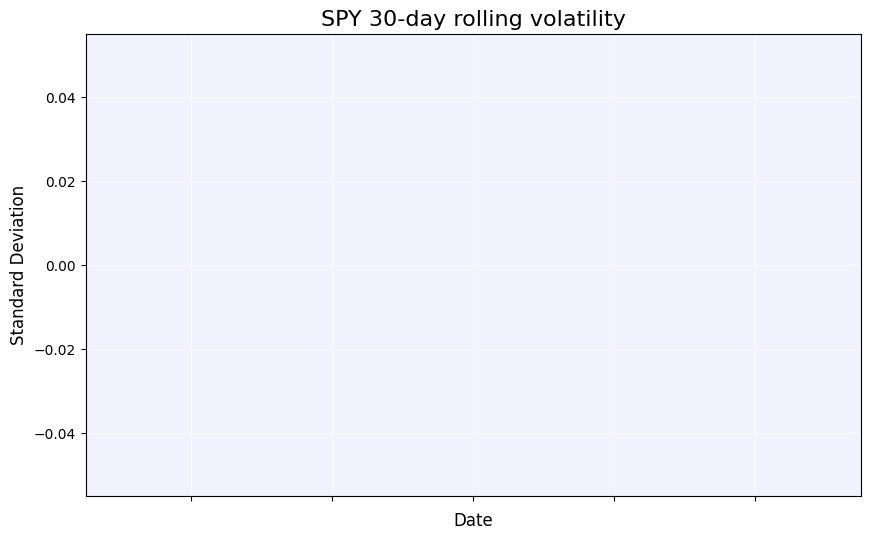

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Fetch historical data for XOM (Exxon Mobil)
today = datetime.datetime.today()

ticker = "spy"
stock_data = yf.download(ticker, start="2020-01-01", end=today)

# Extract adjusted closing prices
prices = stock_data['Adj Close']

# Calculate 30-day rolling standard deviation
rolling_std = prices.rolling(window=30).std()
rolling_std.name = f"{ticker.upper()} 30-day rolling volatility"

# Plot the rolling standard deviation with customized style
plt.figure(figsize=(10, 6))  # Set figure size (width, height)
rolling_std.plot(style='-', color='steelblue', alpha=0.8)  # 'steelblue' is a muted blue color, alpha for transparency
plt.title(rolling_std.name, fontsize=16)  # Set title with larger font size
plt.xlabel("Date", fontsize=12)  # Set x-axis label with font size
plt.ylabel("Standard Deviation", fontsize=12)  # Set y-axis label with font size
plt.grid(True, color='white', linestyle='-', linewidth=0.5)  # Enable white gridlines

# Create a very light blue gradient background
ax = plt.gca()
ax.set_facecolor((0.95, 0.95, 1))  # RGB values for very light blue gradient

# Invert the y-axis
# ax.invert_yaxis()

# Show plot
plt.show()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 8870522239.601194
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4942529275.117597
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1099.3483285599864
Iteration:      4,   Func. Count:     29,   Neg. LLF: 631.3339080633448
Iteration:      5,   Func. Count:     35,   Neg. LLF: 626.5891061200795
Iteration:      6,   Func. Count:     41,   Neg. LLF: 620.8389123662882
Iteration:      7,   Func. Count:     46,   Neg. LLF: 620.833538946223
Iteration:      8,   Func. Count:     51,   Neg. LLF: 620.833353461354
Iteration:      9,   Func. Count:     56,   Neg. LLF: 620.833351819974
Iteration:     10,   Func. Count:     60,   Neg. LLF: 620.8333518205999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 620.833351819974
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                  

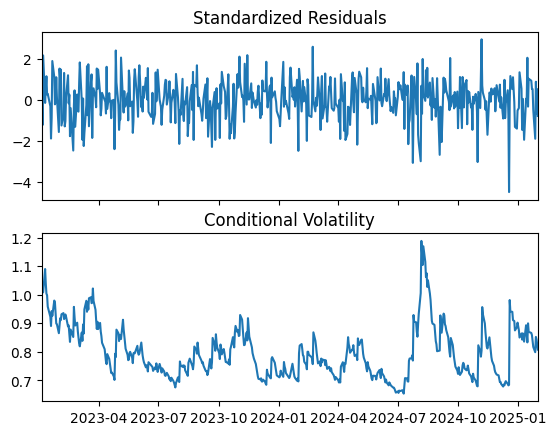

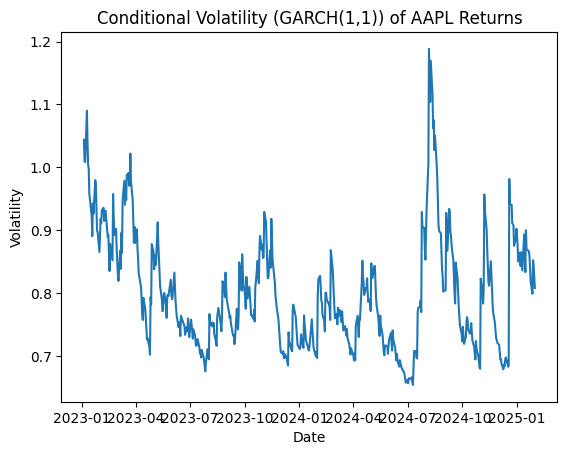

h.1    0.101794
h.2    0.101794
h.3    0.101794
h.4    0.101794
h.5    0.101794
Name: 2025-01-31 00:00:00, dtype: float64
h.1    0.637740
h.2    0.637407
h.3    0.637100
h.4    0.636817
h.5    0.636557
Name: 2025-01-31 00:00:00, dtype: float64


In [4]:
import pandas as pd
import numpy as np
from arch import arch_model
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch historical data for AAPL
ticker = 'spy'
start_date = '2023-01-01'
end_date = '2025-02-01'

data = yf.download(ticker, start=start_date, end=end_date, progress=False)
returns = data['Adj Close'].pct_change().dropna()  # calculate daily returns

# Rescale returns by 100
returns_rescaled = returns * 100

# Specify and fit the GARCH(1,1) model with rescaled data
model = arch_model(returns_rescaled, vol='Garch', p=1, q=1)
results = model.fit()

# Print model summary
print(results.summary())

# Plot standardized residuals
results.plot()

# Plot conditional volatility
fig, ax = plt.subplots()
ax.plot(results.conditional_volatility)
ax.set_title('Conditional Volatility (GARCH(1,1)) of AAPL Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
plt.show()

# Forecast volatility for the next 5 days
forecasts = results.forecast(horizon=5)
print(forecasts.mean.iloc[-1])  # Forecasted mean volatility
print(forecasts.variance.iloc[-1])  # Forecasted variance


2025-09-02    2.70
2025-09-03    3.00
2025-09-04    3.11
2025-09-05    3.05
2025-09-08    3.10
dtype: float64
2025-09-08
ModeResult(mode=2.75, count=42)


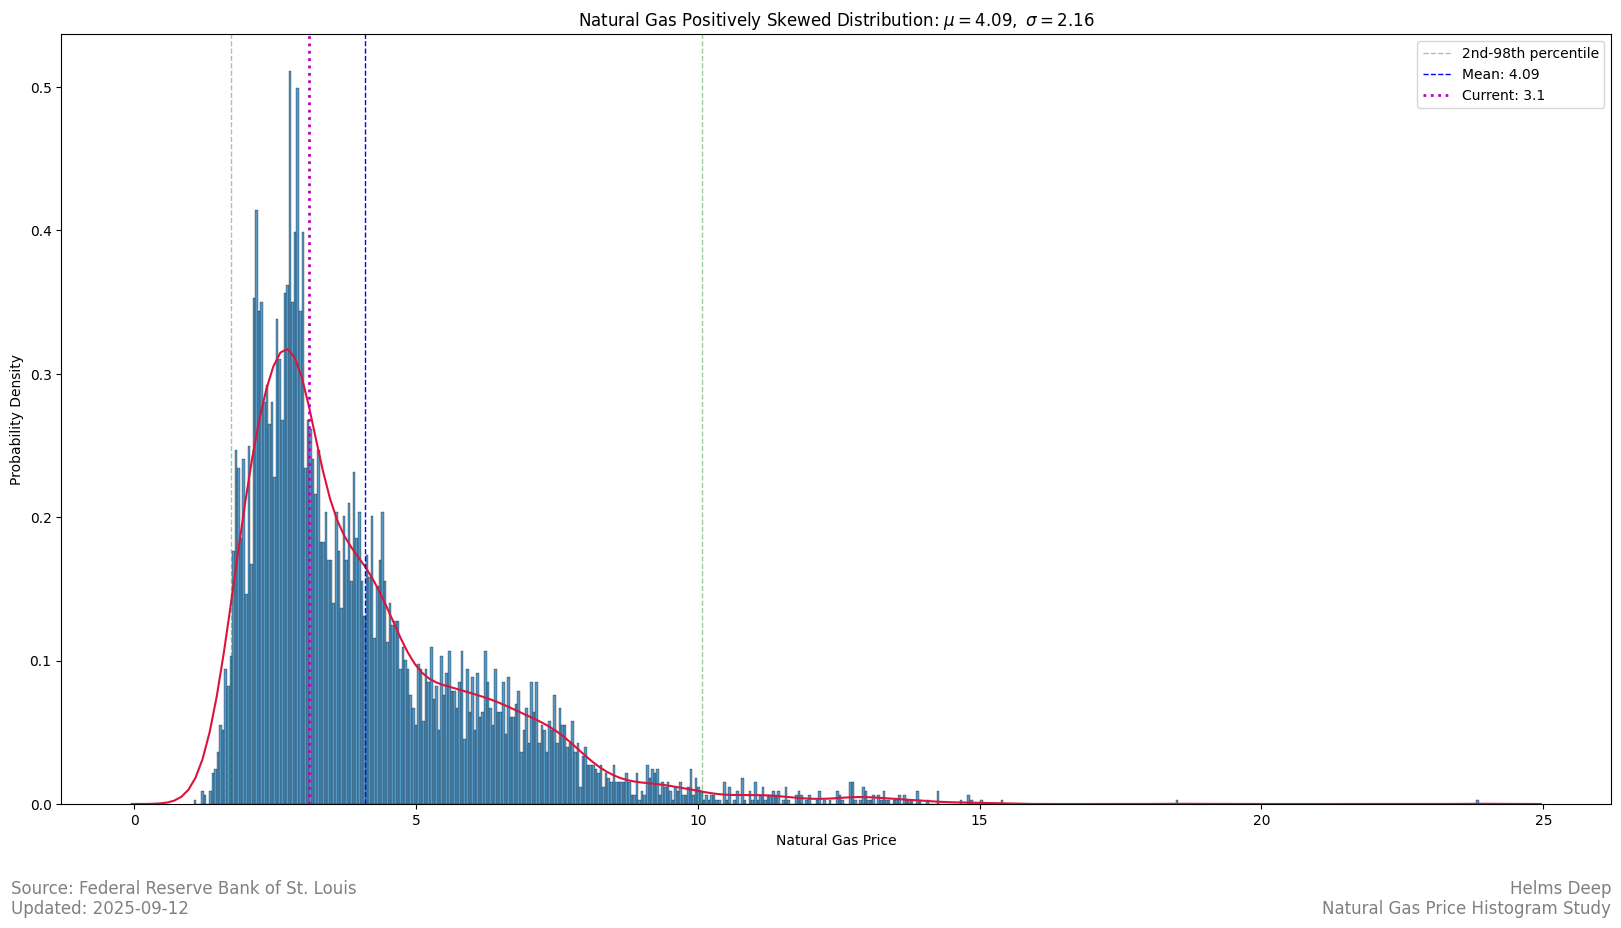

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import importlib
import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def fetch_gas_data():
    """
    Fetch Henry Hub Natural Gas Spot Price data from the FRED API using SeriesFetcher.
    
    Returns:
        pd.Series: A series containing Natural Gas data.
    """
    gas_series = SeriesFetcher('DHHNGSP')
    gas_df = gas_series.get_series_data()
    return gas_df

def plot_gas_distribution(gas_df):
    """
    Plot the distribution and statistics of Natural Gas data.

    Parameters:
        gas_df (pd.Series): A series containing Natural Gas data.
    """
    today = pd.Timestamp.now().date()
    mu = np.mean(gas_df)
    sigma = np.std(gas_df)

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.histplot(gas_df, bins=500, stat='density', kde=False)
    sns.kdeplot(gas_df, color='crimson')

    ax.set_xlabel('Natural Gas Price')
    ax.set_ylabel('Probability Density')
    ax.set_title(r'Natural Gas Positively Skewed Distribution: $\mu={:.2f},\ \sigma={:.2f}$'.format(mu, sigma))
    
    ax.axvline(np.percentile(gas_df, 2), color='g', alpha=0.4, linestyle='dashed', linewidth=1, label='2nd-98th percentile')
    ax.axvline(np.percentile(gas_df, 98), color='g', alpha=0.4, linestyle='dashed', linewidth=1)
    ax.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Mean: {round(mu, 2)}')
    ax.axvline(gas_df.iloc[-1], color='m', linestyle=':', linewidth=2, label=f'Current: {gas_df.iloc[-1]}')

    most_recent_date = gas_df.index.max()
    print(most_recent_date)
    print(stats.mode(gas_df))

    # Add signature text to the plot
    signature_text = 'Helms Deep\nNatural Gas Price Histogram Study'
    plt.figtext(.9, 0, signature_text, ha='right', fontsize=12, color='grey')
    
    # Add source from FRED St. Louis on the left
    plt.figtext(0.1, 0, f'Source: Federal Reserve Bank of St. Louis\nUpdated: {today}', ha='left', fontsize=12, color='grey')

    plt.legend(loc="upper right")
    plt.show()

if __name__ == "__main__":
    gas_df = fetch_gas_data()
    print(gas_df.tail())
    plot_gas_distribution(gas_df)


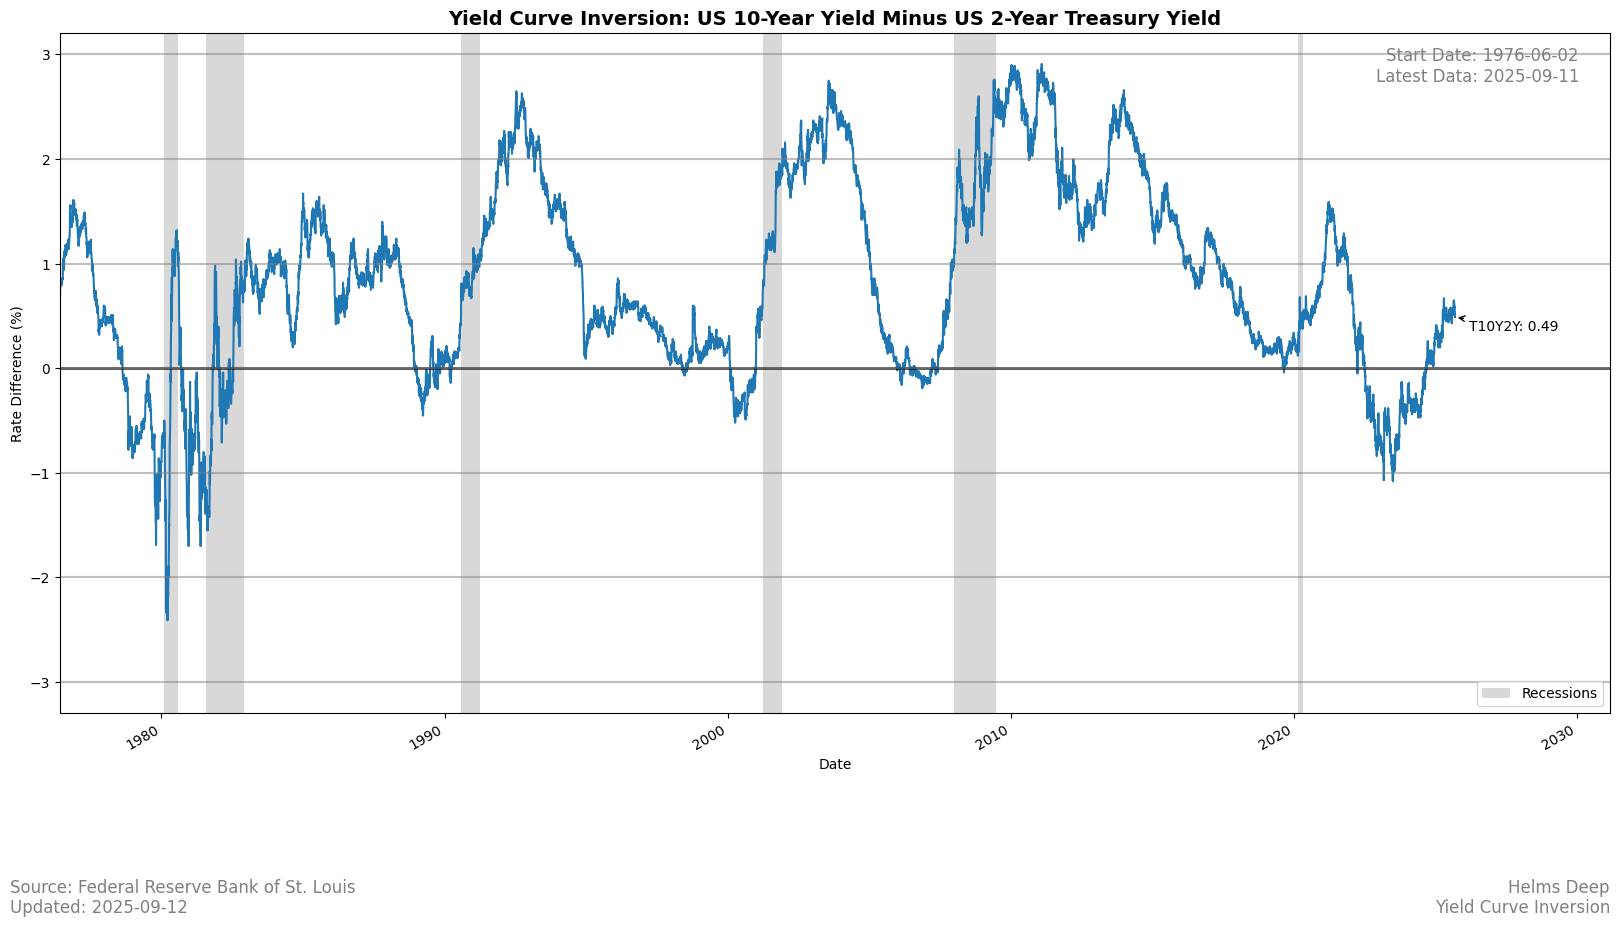

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher

def constructDF():
    """
    Constructs the DataFrame by fetching the yield curve difference data from the FRED API.

    Returns:
        pd.DataFrame: DataFrame containing the data for 'T10Y2Y'.
    """
    T10Y2Y = SeriesFetcher('T10Y2Y')

    data = pd.DataFrame({
        'T10Y2Y': T10Y2Y.get_series_data(),
    })

    # Drop rows with missing values
    data.dropna(inplace=True)
    
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    
    return data

def shade_recession_months(ax, usrec_series):
    """
    Shades the recession months based on the "USREC" series.

    Parameters:
        ax (matplotlib.axes.Axes): The Axes object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            ax.axvspan(date, date + pd.DateOffset(months=1), color='grey', alpha=0.3, linewidth=0)

if __name__ == "__main__":
    offset_days = 2000
    
    # Construct the DataFrame
    data_df = constructDF()
    # Set a arbitrary start date if not provided and today's date
    today = pd.Timestamp.now().date()
    start_date = None
    if start_date is None:
        start_date = data_df.index[1]
    
    # Filter the DataFrame based on the arbitrary start date
    data_filtered = data_df.loc[start_date:]
    
    # Plot the filtered data
    fig, ax = plt.subplots(figsize=(20, 10))
    data_filtered.plot(ax=ax, legend=None)
    
    plt.title('Yield Curve Inversion: US 10-Year Yield Minus US 2-Year Treasury Yield', fontsize=14, weight='bold')
    plt.xlabel('Date')
    plt.ylabel('Rate Difference (%)')
    
    # Set x-axis limits to include additional offset days
    x_min = data_filtered.index.min()
    x_max = data_filtered.index.max() + pd.DateOffset(days=offset_days)
    plt.xlim(x_min, x_max)
    
    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data()
    shade_recession_months(ax, usrec_series)
    recession_legend = plt.Rectangle((0,0), 0, 0, fc='grey', alpha=0.3, label='Recessions')

    # Annotate the end values of specific columns on the plot
    for column in ['T10Y2Y']:
        end_date = data_filtered.index[-1]
        end_value = data_filtered[column].iloc[-1]
        plt.annotate(f'{column}: {end_value:.2f}', xy=(end_date, end_value),
                     xytext=(10, -10), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->"))
        
    # Add most recent date and arbitrary start date
    most_recent_date = data_df.index.max()
    plt.text(0.98, 0.98, f'Start Date: {start_date.date()}\nLatest Data: {most_recent_date.date()}', 
             transform=plt.gca().transAxes, fontsize=12, color='grey', ha='right', va='top')
    
    # Add signature text to the plot
    signature_text = 'Helms Deep\nYield Curve Inversion'
    plt.figtext(.9, 0, signature_text, ha='right', fontsize=12, color='grey')

    # Add a baseline at 0 showing the difference between 10-year yield vs. 2-year yield
    plt.axhline(y=0, color='black', linewidth=2, linestyle='-', alpha=0.7)
    
    # Add source from FRED St. Louis on the left
    plt.figtext(0.1, 0, f'Source: Federal Reserve Bank of St. Louis\nUpdated: {today}', ha='left', fontsize=12, color='grey')

    # Add gradient lines at each whole number on the y-axis
    y_ticks = np.arange(np.floor(data_filtered['T10Y2Y'].min()), np.ceil(data_filtered['T10Y2Y'].max()) + 1)
    for y in y_ticks:
        ax.axhline(y=y, color='gray', linestyle='-', alpha=0.5)
    
    plt.legend(handles=[recession_legend], loc="lower right")
    
    # Display the plot and save the figure 
    plt.show()
    fig.savefig('yield_curve_difference.png', bbox_inches='tight')


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic SPX price data
today = pd.Timestamp.now().date()
np.random.seed(42)
dates = pd.date_range(start='2024-04-01', end=today = pd.Timestamp.now().date(), freq='B')  # Business days within 1 year
n = len(dates)
price = np.cumprod(1 + np.random.normal(0, 0.01, n)) * 4000  # Simulate SPX price starting at 4000

# Create a DataFrame
df = pd.DataFrame(data={'Date': dates, 'Close': price})
df.set_index('Date', inplace=True)

# Calculate Historical Volatility (HV)
df['Returns'] = df['Close'].pct_change()
df['HV'] = df['Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Simulate Implied Volatility (IV) by adding random noise to HV
df['IV'] = df['HV'] + np.random.normal(0, 0.05, n)  # Adding some random noise for illustration

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['HV'], label='Historical Volatility (HV)')
plt.plot(df.index, df['IV'], label='Implied Volatility (IV)', linestyle='--')
plt.title('SPX Historical Volatility (HV) and Implied Volatility (IV)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


SyntaxError: invalid syntax (4115655477.py, line 8)

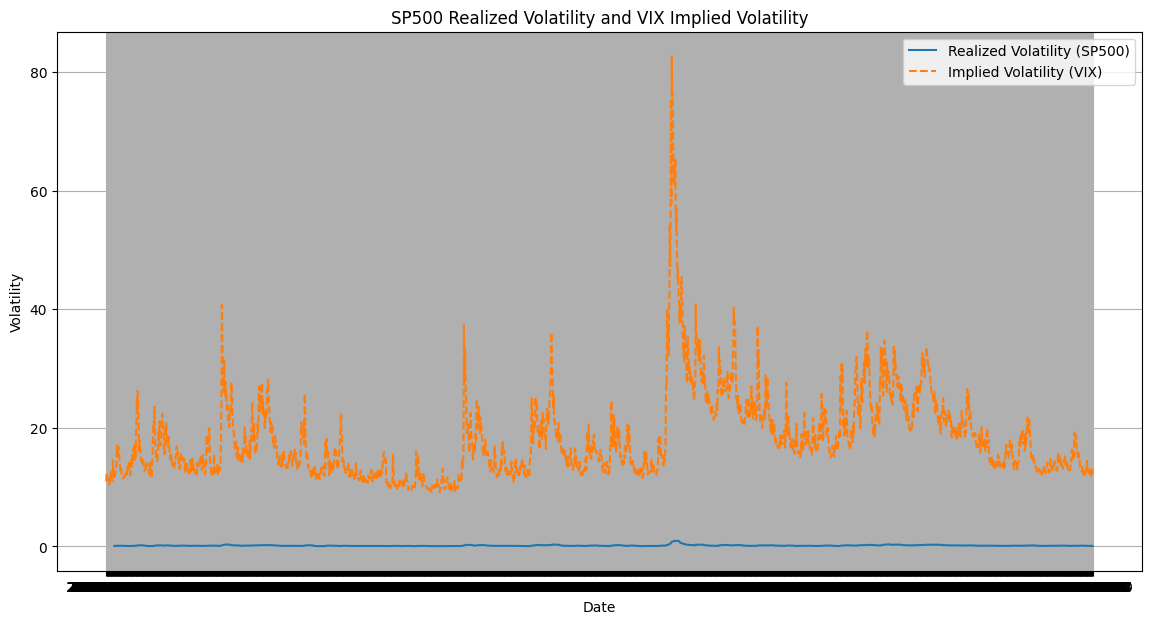

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from src.fetcher import SeriesFetcher

# Fetch VIXCLS data (Implied Volatility)
vix_fetcher = SeriesFetcher('VIXCLS')
vix_data = vix_fetcher.get_series_data()

# Fetch SP500 data (Index)
sp500_fetcher = SeriesFetcher('SP500')
sp500_data = sp500_fetcher.get_series_data()

# Align the data by date
data = pd.DataFrame({
    'SP500': sp500_data,
    'VIX': vix_data
}).dropna()

# Calculate Historical (Realized) Volatility
data['Returns'] = data['SP500'].pct_change()
data['RealizedVol'] = data['Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['RealizedVol'], label='Realized Volatility (SP500)')
plt.plot(data.index, data['VIX'], label='Implied Volatility (VIX)', linestyle='--')
plt.title('SP500 Realized Volatility and VIX Implied Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


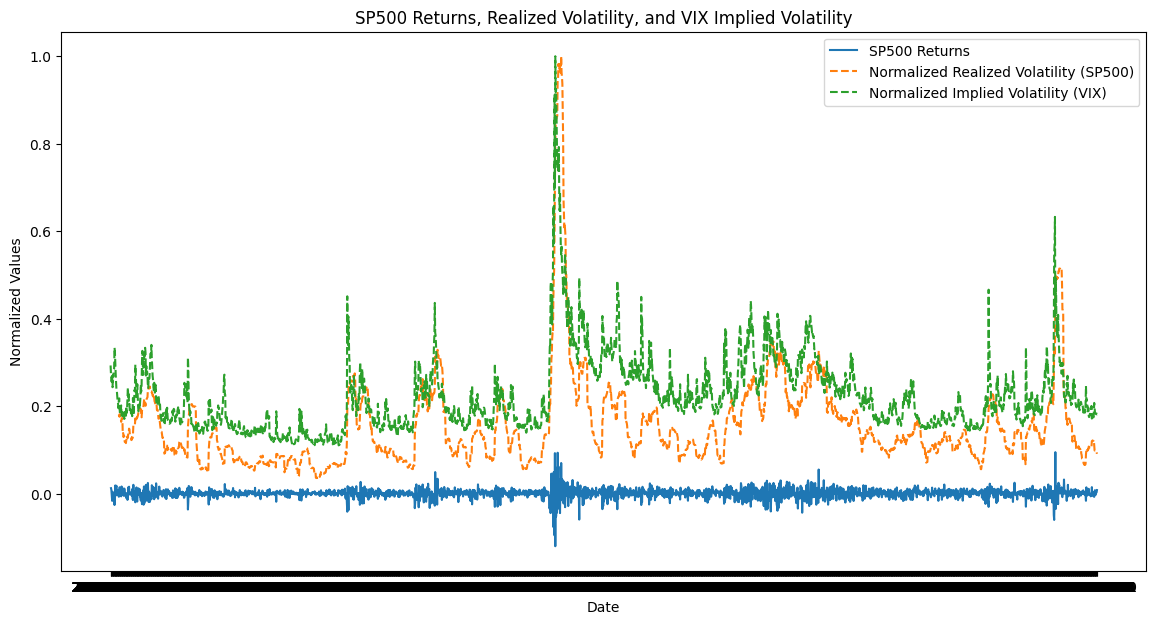

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from src.fetcher import SeriesFetcher

# Fetch VIXCLS data (Implied Volatility)
vix_fetcher = SeriesFetcher('VIXCLS')
vix_data = vix_fetcher.get_series_data()

# Fetch SP500 data (Index)
sp500_fetcher = SeriesFetcher('SP500')
sp500_data = sp500_fetcher.get_series_data()

# Align the data by date
data = pd.DataFrame({
    'SP500': sp500_data,
    'VIX': vix_data
}).dropna()

# Calculate Historical (Realized) Volatility
data['Returns'] = data['SP500'].pct_change()
data['RealizedVol'] = data['Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Normalize the volatilities
data['NormalizedRealizedVol'] = data['RealizedVol'] / data['RealizedVol'].max()
data['NormalizedVIX'] = data['VIX'] / data['VIX'].max()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns'], label='SP500 Returns')
plt.plot(data.index, data['NormalizedRealizedVol'], label='Normalized Realized Volatility (SP500)', linestyle='--')
plt.plot(data.index, data['NormalizedVIX'], label='Normalized Implied Volatility (VIX)', linestyle='--')
plt.title('SP500 Returns, Realized Volatility, and VIX Implied Volatility')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
# plt.grid(True)
plt.show()


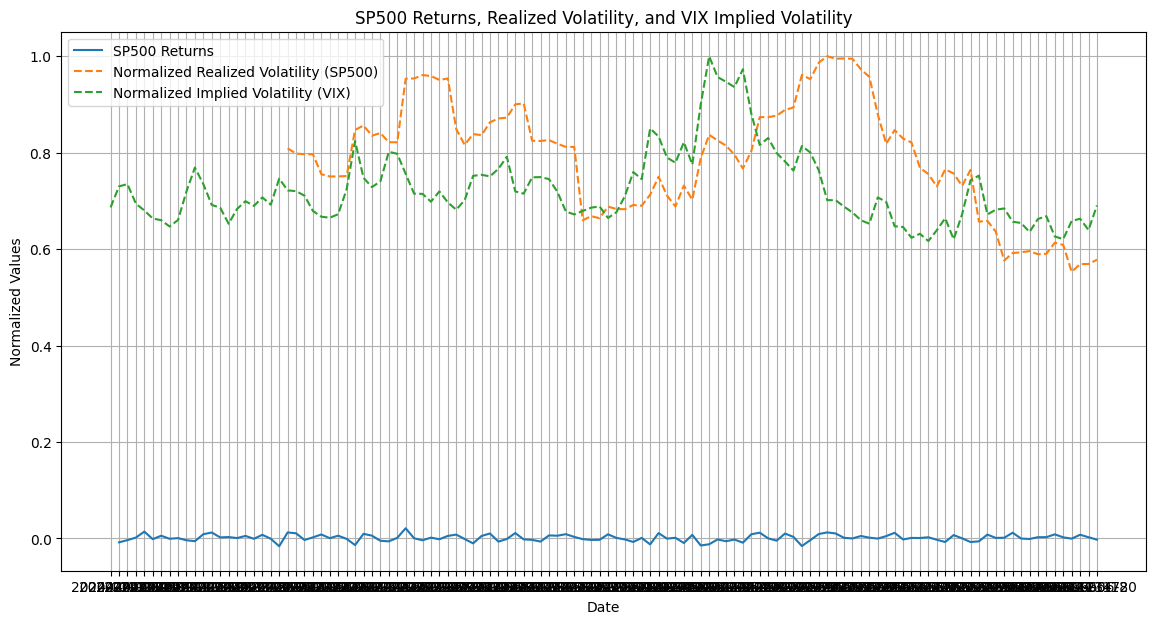

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from src.fetcher import SeriesFetcher

# Fetch VIXCLS data (Implied Volatility)
vix_fetcher = SeriesFetcher('VIXCLS')
vix_data = vix_fetcher.get_series_data()

# Fetch SP500 data (Index)
sp500_fetcher = SeriesFetcher('SP500')
sp500_data = sp500_fetcher.get_series_data()

# Align the data by date
data = pd.DataFrame({
    'SP500': sp500_data,
    'VIX': vix_data
}).dropna()

# Specify start date (change as per your requirement)
start_date = '2024-01-01'

# Filter data based on start date
data = data[data.index >= start_date]

# Calculate Historical (Realized) Volatility
data['Returns'] = data['SP500'].pct_change()
data['RealizedVol'] = data['Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Normalize the volatilities
data['NormalizedRealizedVol'] = data['RealizedVol'] / data['RealizedVol'].max()
data['NormalizedVIX'] = data['VIX'] / data['VIX'].max()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns'], label='SP500 Returns')
plt.plot(data.index, data['NormalizedRealizedVol'], label='Normalized Realized Volatility (SP500)', linestyle='--')
plt.plot(data.index, data['NormalizedVIX'], label='Normalized Implied Volatility (VIX)', linestyle='--')
plt.title('SP500 Returns, Realized Volatility, and VIX Implied Volatility')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.show()


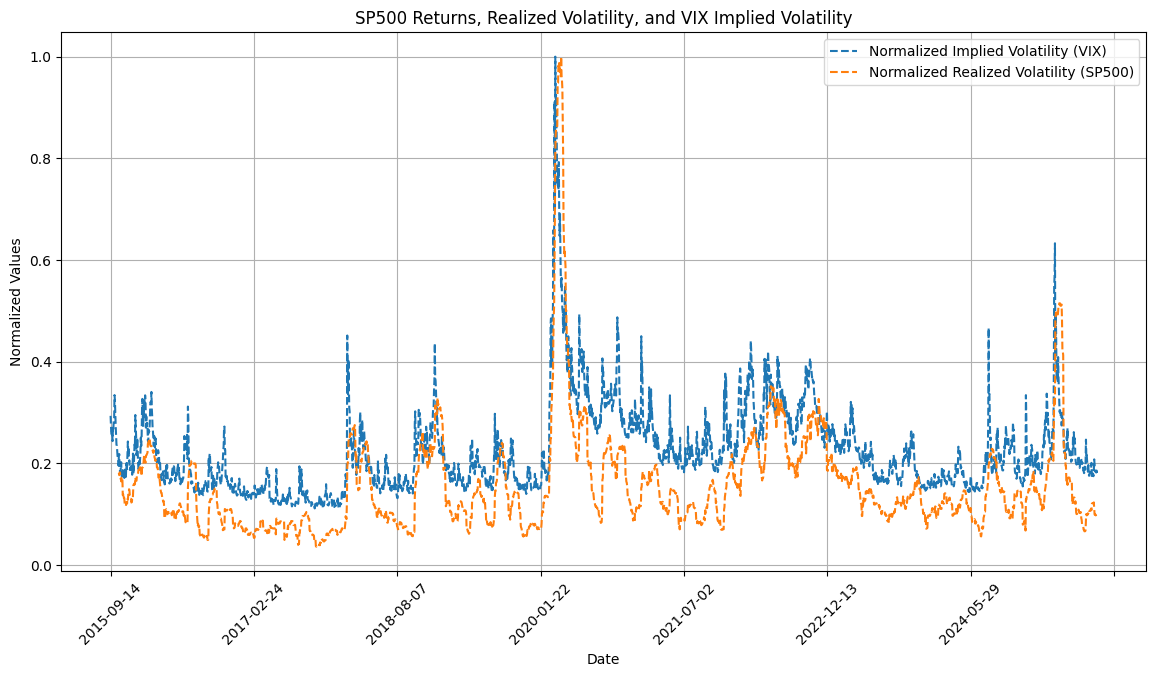

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.fetcher import SeriesFetcher

# Fetch VIXCLS data (Implied Volatility)
vix_fetcher = SeriesFetcher('VIXCLS')
vix_data = vix_fetcher.get_series_data()

# Fetch SP500 data (Index)
sp500_fetcher = SeriesFetcher('SP500')
sp500_data = sp500_fetcher.get_series_data()

# Align the data by date
data = pd.DataFrame({
    'SP500': sp500_data,
    'VIX': vix_data
}).dropna()

# Calculate Historical (Realized) Volatility
data['Returns'] = data['SP500'].pct_change()
data['RealizedVol'] = data['Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Normalize the volatilities
data['NormalizedRealizedVol'] = data['RealizedVol'] / data['RealizedVol'].max()
data['NormalizedVIX'] = data['VIX'] / data['VIX'].max()

# Plotting
plt.figure(figsize=(14, 7))
# plt.plot(data.index, data['Returns'], label='SP500 Returns')
plt.plot(data.index, data['NormalizedVIX'], label='Normalized Implied Volatility (VIX)', linestyle='--')
plt.plot(data.index, data['NormalizedRealizedVol'], label='Normalized Realized Volatility (SP500)', linestyle='--')
plt.title('SP500 Returns, Realized Volatility, and VIX Implied Volatility')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)

# Format the x-axis to show dates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.show()


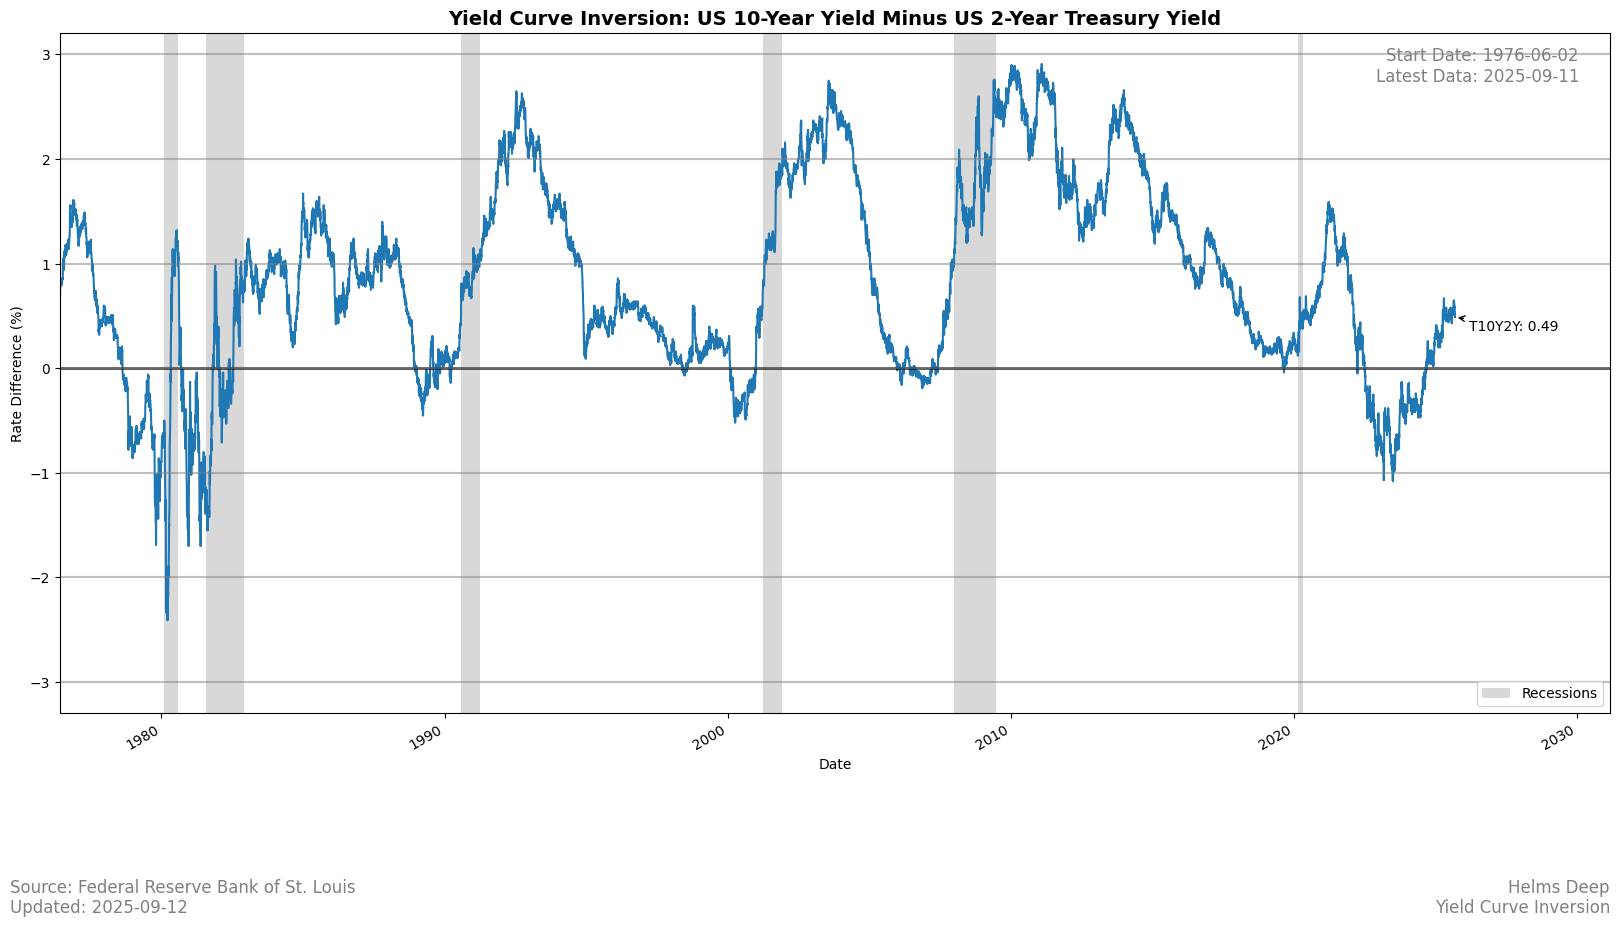

In [8]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher

def constructDF():
    """
    Constructs the DataFrame by fetching the yield curve difference data from the FRED API.

    Returns:
        pd.DataFrame: DataFrame containing the data for 'T10Y2Y'.
    """
    T10Y2Y = SeriesFetcher('T10Y2Y')

    data = pd.DataFrame({
        'T10Y2Y': T10Y2Y.get_series_data(),
    })

    # Drop rows with missing values
    data.dropna(inplace=True)
    
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    
    return data

def shade_recession_months(ax, usrec_series):
    """
    Shades the recession months based on the "USREC" series.

    Parameters:
        ax (matplotlib.axes.Axes): The Axes object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            ax.axvspan(date, date + pd.DateOffset(months=1), color='grey', alpha=0.3, linewidth=0)

if __name__ == "__main__":
    offset_days = 2000
    
    # Construct the DataFrame
    data_df = constructDF()
    # Set a arbitrary start date if not provided and today's date
    today = pd.Timestamp.now().date()
    start_date = None
    if start_date is None:
        start_date = data_df.index[1]
    
    # Filter the DataFrame based on the arbitrary start date
    data_filtered = data_df.loc[start_date:]
    
    # Plot the filtered data
    fig, ax = plt.subplots(figsize=(20, 10))
    data_filtered.plot(ax=ax, legend=None)
    
    plt.title('Yield Curve Inversion: US 10-Year Yield Minus US 2-Year Treasury Yield', fontsize=14, weight='bold')
    plt.xlabel('Date')
    plt.ylabel('Rate Difference (%)')
    
    # Set x-axis limits to include additional offset days
    x_min = data_filtered.index.min()
    x_max = data_filtered.index.max() + pd.DateOffset(days=offset_days)
    plt.xlim(x_min, x_max)
    
    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data()
    shade_recession_months(ax, usrec_series)
    recession_legend = plt.Rectangle((0,0), 0, 0, fc='grey', alpha=0.3, label='Recessions')

    # Annotate the end values of specific columns on the plot
    for column in ['T10Y2Y']:
        end_date = data_filtered.index[-1]
        end_value = data_filtered[column].iloc[-1]
        plt.annotate(f'{column}: {end_value:.2f}', xy=(end_date, end_value),
                     xytext=(10, -10), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->"))
        
    # Add most recent date and arbitrary start date
    most_recent_date = data_df.index.max()
    plt.text(0.98, 0.98, f'Start Date: {start_date.date()}\nLatest Data: {most_recent_date.date()}', 
             transform=plt.gca().transAxes, fontsize=12, color='grey', ha='right', va='top')
    
    # Add signature text to the plot
    signature_text = 'Helms Deep\nYield Curve Inversion'
    plt.figtext(.9, 0, signature_text, ha='right', fontsize=12, color='grey')

    # Add a baseline at 0 showing the difference between 10-year yield vs. 2-year yield
    plt.axhline(y=0, color='black', linewidth=2, linestyle='-', alpha=0.7)
    
    # Add source from FRED St. Louis on the left
    plt.figtext(0.1, 0, f'Source: Federal Reserve Bank of St. Louis\nUpdated: {today}', ha='left', fontsize=12, color='grey')

    # Add gradient lines at each whole number on the y-axis
    y_ticks = np.arange(np.floor(data_filtered['T10Y2Y'].min()), np.ceil(data_filtered['T10Y2Y'].max()) + 1)
    for y in y_ticks:
        ax.axhline(y=y, color='gray', linestyle='-', alpha=0.5)
    
    plt.legend(handles=[recession_legend], loc="lower right")
    
    # Display the plot and save the figure 
    plt.show()
    fig.savefig('yield_curve_difference.png', bbox_inches='tight')


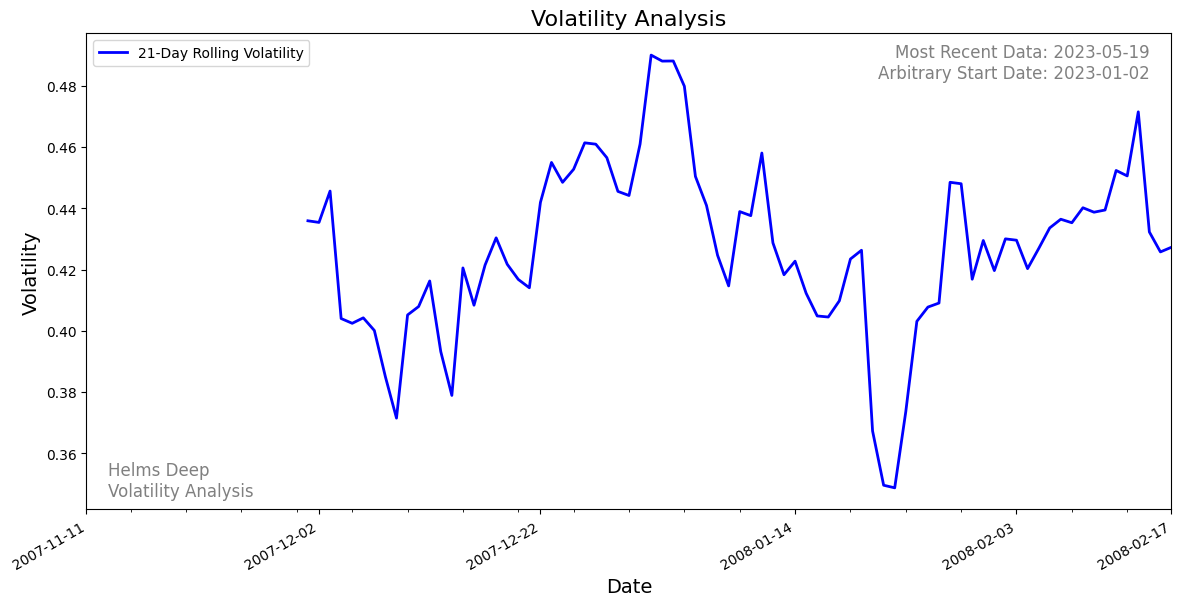

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Generate some example data
dates = pd.date_range(start='2023-01-01', periods=100, freq='B')
prices = np.random.lognormal(mean=0, sigma=0.02, size=len(dates))
data = pd.DataFrame({'Price': prices}, index=dates)

# Calculate returns and volatility
returns = data['Price'].pct_change().dropna()
volatility = returns.rolling(window=21).std() * np.sqrt(252)  # Annualized volatility

# Prepare the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the volatility
volatility.plot(ax=ax, color='blue', lw=2, label='21-Day Rolling Volatility')

# Format the x-axis to show dates properly
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

# Add title and labels
plt.title('Volatility Analysis', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.legend()

# Add additional text for the most recent and arbitrary start dates
most_recent_date = pd.to_datetime(data.index.max())
arbitrary_start_date = pd.to_datetime(data.index.min())

plt.text(0.98, 0.98, f'Most Recent Data: {most_recent_date.date()}\nArbitrary Start Date: {arbitrary_start_date.date()}', 
         transform=plt.gca().transAxes, fontsize=12, color='grey', ha='right', va='top')

# Add signature text to the plot
signature_text = 'Helms Deep\nVolatility Analysis'
plt.text(0.02, 0.02, signature_text, transform=plt.gca().transAxes, fontsize=12, color='grey', ha='left', va='bottom')

plt.show()


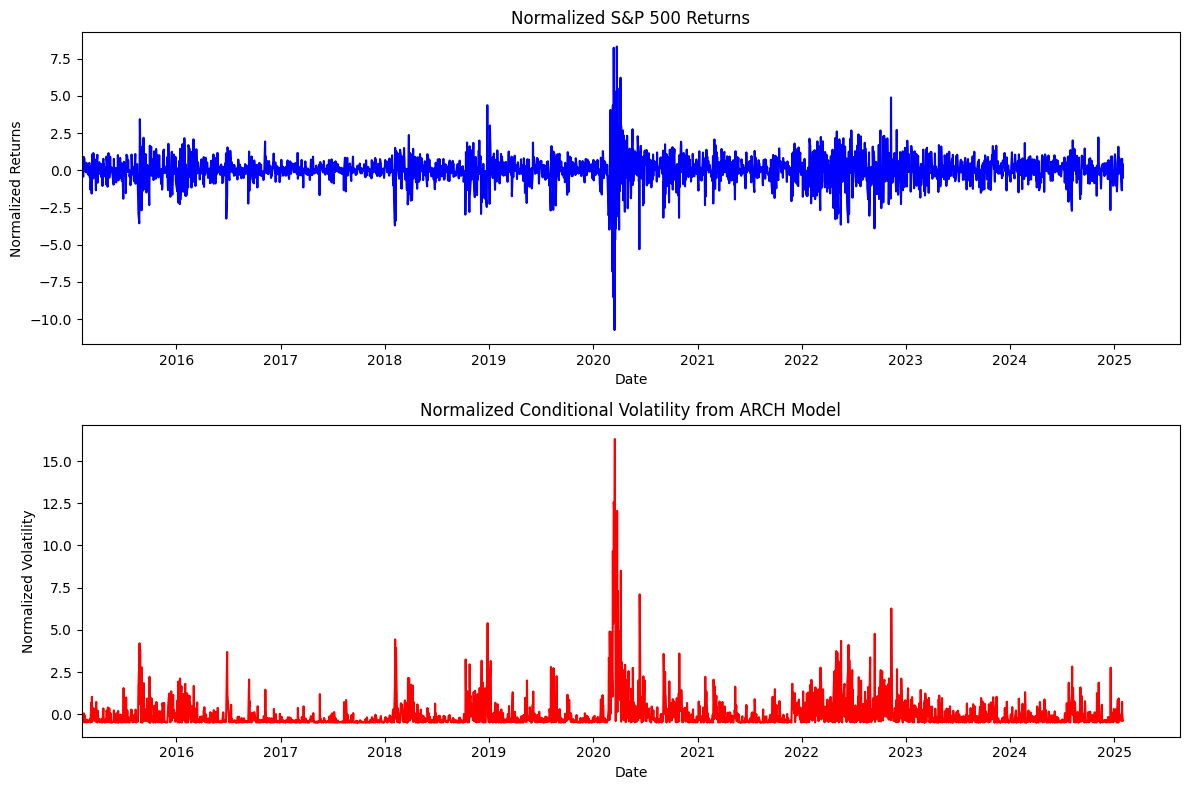

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from src.fetcher import SeriesFetcher

# Step 1: Fetch the data
series_id = 'SP500'  # S&P 500 index
fetcher = SeriesFetcher(series_id)
data = fetcher.get_series_data()

# Ensure the index is in datetime format
data.index = pd.to_datetime(data.index)

# Define the arbitrary start date
# start_date = '2020-01-01'  # Replace with your desired start date
start_date = data.index[1]

# Filter data based on start date
data = data.loc[start_date:]

# Step 2: Prepare the data
returns = data.pct_change().dropna() * 100  # Convert to percentage returns

# Step 3: Fit the ARCH model
model = arch_model(returns, vol='ARCH', p=1)
model_fit = model.fit(disp='off')

# Extract conditional volatility
conditional_volatility = model_fit.conditional_volatility

# Normalize returns and conditional volatility
returns_normalized = (returns - returns.mean()) / returns.std()
conditional_volatility_normalized = (conditional_volatility - conditional_volatility.mean()) / conditional_volatility.std()

# Plotting the normalized returns and conditional volatility
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot normalized returns
ax[0].plot(returns_normalized, color='blue')
ax[0].set_title('Normalized S&P 500 Returns')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Normalized Returns')

# Plot normalized conditional volatility
ax[1].plot(conditional_volatility_normalized, color='red')
ax[1].set_title('Normalized Conditional Volatility from ARCH Model')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Normalized Volatility')

# Set x-axis limits to include additional offset days
offset_days = 200
x_min = data.index.min()
x_max = data.index.max() + pd.DateOffset(days=offset_days)
for a in ax:
    a.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()


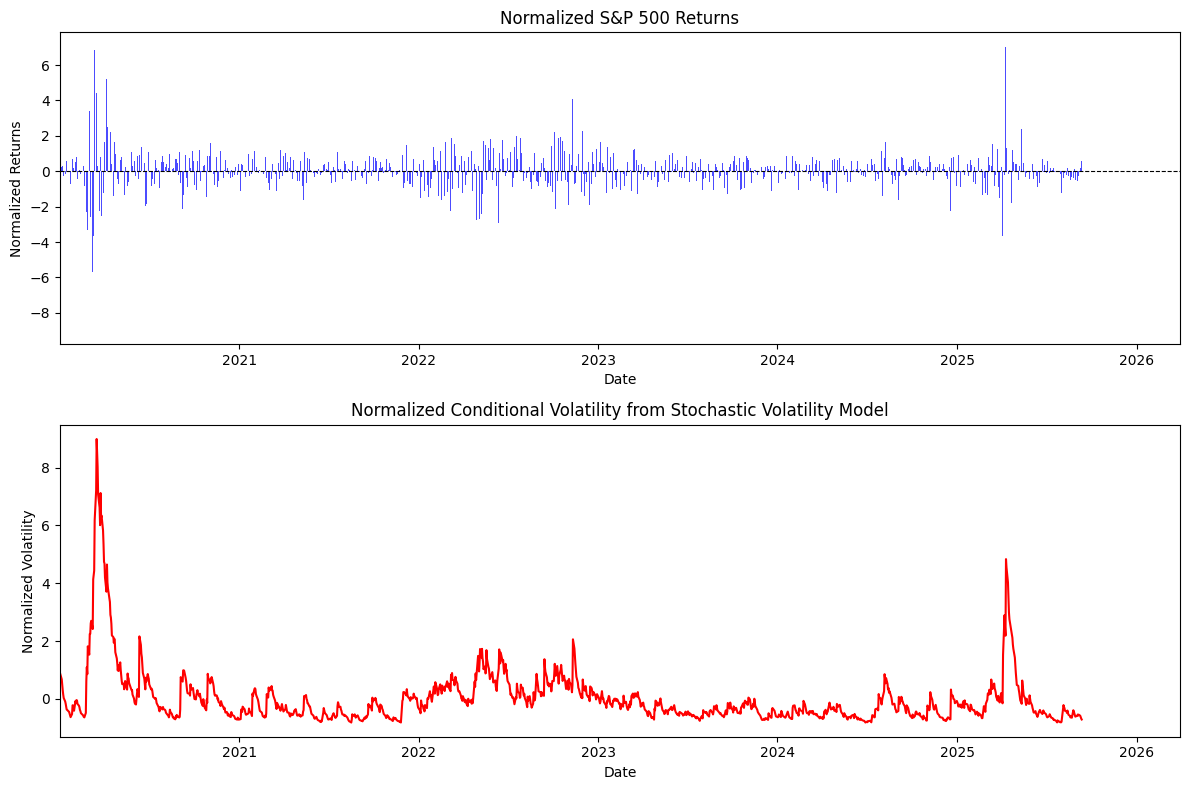

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from src.fetcher import SeriesFetcher

# Step 1: Fetch the data
series_id = 'SP500'  # S&P 500 index
fetcher = SeriesFetcher(series_id)
data = fetcher.get_series_data()

# Ensure the index is in datetime format
data.index = pd.to_datetime(data.index)

# Define the arbitrary start date
start_date = '2020-01-01'  # Replace with your desired start date

# Filter data based on start date
data = data.loc[start_date:]

# Step 2: Prepare the data
returns = data.pct_change().dropna() * 100  # Convert to percentage returns

# Step 3: Fit a Stochastic Volatility (SV) model
model = arch_model(returns, vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

# Extract conditional volatility
conditional_volatility = model_fit.conditional_volatility

# Normalize returns and conditional volatility
returns_normalized = (returns - returns.mean()) / returns.std()
conditional_volatility_normalized = (conditional_volatility - conditional_volatility.mean()) / conditional_volatility.std()

# Plotting the normalized returns and conditional volatility
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot normalized returns as bars
ax[0].bar(returns_normalized.index, returns_normalized.values, color='blue', alpha=0.7, width=1)
ax[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Add a horizontal line at y=0
ax[0].set_title('Normalized S&P 500 Returns')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Normalized Returns')

# Plot normalized conditional volatility
ax[1].plot(conditional_volatility_normalized, color='red')
ax[1].set_title('Normalized Conditional Volatility from Stochastic Volatility Model')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Normalized Volatility')

# Set x-axis limits to include additional offset days
offset_days = 200
x_min = data.index.min()
x_max = data.index.max() + pd.DateOffset(days=offset_days)
for a in ax:
    a.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

In [103]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher

# Fetch VIXCLS data (Implied Volatility)
vix_fetcher = SeriesFetcher('VIXCLS')
vix_data = vix_fetcher.get_series_data()

# Fetch SP500 data (Index)
sp500_fetcher = SeriesFetcher('SP500')
sp500_data = sp500_fetcher.get_series_data()

# Align the data by date
data = pd.DataFrame({
    'SP500': sp500_data,
    'VIX': vix_data
}).dropna()

# Convert index to datetime
data.index = pd.to_datetime(data.index)

# Specify start date (change as per your requirement)
start_date = '2020-01-01'  # Replace with your desired start date

# Filter data based on start date
data = data.loc[start_date:]

# Calculate Historical (Realized) Volatility
data['Returns'] = data['SP500'].pct_change()
data['RealizedVol'] = data['Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Normalize the volatilities
data['NormalizedRealizedVol'] = data['RealizedVol'] / data['RealizedVol'].max()
data['NormalizedVIX'] = data['VIX'] / data['VIX'].max()

# Create target labels (1 if volatility exceeds threshold, 0 otherwise)
threshold = 0.01  # Adjusted threshold
data['VolatilityExceedsThreshold'] = (data['RealizedVol'] > threshold).astype(int)

# Drop rows with NaN values
data = data.dropna()

# Print summary statistics to debug
print("Summary statistics of RealizedVol:")
print(data['RealizedVol'].describe())

# Print some examples of RealizedVol and VolatilityExceedsThreshold to inspect
print("\nExamples of RealizedVol and VolatilityExceedsThreshold:")
print(data[['RealizedVol', 'VolatilityExceedsThreshold']].head(10))

# Create features and labels
X = data[['NormalizedVIX', 'NormalizedRealizedVol']].shift(1).dropna()
y = data['VolatilityExceedsThreshold'][1:]  # Skip the first label due to the shift

# Ensure the indices match
X = X.loc[y.index]

# Check unique values in y_train to debug
print("\nUnique values in y_train:", y.unique())

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check if y_train contains only one class
if len(np.unique(y_train)) < 2:
    raise ValueError("Not enough classes in y_train. Adjust threshold or check data.")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Print classification report
print(classification_report(y_test, y_pred))

# Plot the actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['NormalizedRealizedVol'], label='Normalized Realized Volatility (SP500)', linestyle='--')
plt.plot(data.index, data['NormalizedVIX'], label='Normalized Implied Volatility (VIX)', linestyle='--')
plt.scatter(X_test.index, y_pred_prob, color='red', label='Predicted Probability of Exceeding Threshold', alpha=0.5)
plt.title('SP500 Returns, Realized Volatility, and VIX Implied Volatility with Predictions')
plt.xlabel('Date')
plt.ylabel('Normalized Values and Predicted Probabilities')
plt.legend()

plt.show()


Summary statistics of RealizedVol:
count    1106.000000
mean        0.183502
std         0.126955
min         0.066809
25%         0.112723
50%         0.151752
75%         0.212939
max         0.968347
Name: RealizedVol, dtype: float64

Examples of RealizedVol and VolatilityExceedsThreshold:
            RealizedVol  VolatilityExceedsThreshold
2020-02-03     0.117794                           1
2020-02-04     0.125863                           1
2020-02-05     0.130612                           1
2020-02-06     0.129902                           1
2020-02-07     0.131500                           1
2020-02-10     0.131876                           1
2020-02-11     0.131076                           1
2020-02-12     0.130810                           1
2020-02-13     0.130843                           1
2020-02-14     0.130842                           1

Unique values in y_train: [1]


ValueError: Not enough classes in y_train. Adjust threshold or check data.